# Ensemble 과제2
- 데이터 선정 후 EDA, Ensemble 진행
- 조건: Ensemble model 3개 이상 (stacking 방법 포함)

In [24]:
cd C:/Users/jhr50/Desktop/Bigdata&AI/공모전/빅콘테스트/2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)

C:\Users\jhr50\Desktop\Bigdata&AI\공모전\빅콘테스트\2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)


In [98]:
# ready
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization
from matplotlib import pyplot as plt
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

import time 
import datetime

## 데이터 불러오기
- 데이터 선정: 빅콘테스트 NS SHOP+ 편성데이터

In [63]:
# Load Data
train = pd.read_csv('./01_제공데이터/train.csv')
test = pd.read_csv('./02_평가데이터/test.csv')

In [26]:
train.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 6:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","2,099,000"
1,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","4,371,000"
2,2019-01-01 6:20,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","3,262,000"
3,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","6,955,000"
4,2019-01-01 6:40,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","6,672,000"


In [27]:
test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 6:20,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
1,2020-06-01 6:40,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 7:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:20,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
4,2020-06-01 7:40,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN


## EDA & Data Preprocessing

-  데이터 확인 및 결측치 확인

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
방송일시     38309 non-null object
노출(분)    21525 non-null float64
마더코드     38309 non-null int64
상품코드     38309 non-null int64
상품명      38309 non-null object
상품군      38309 non-null object
판매단가     38309 non-null object
 취급액     37372 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 2.3+ MB


노출(분)의 데이터에 결측치가 다량 존재하고, 취급액 역시 결측치가 존재하는 것을 확인하였습니다. 

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 8 columns):
방송일시     2891 non-null object
노출(분)    1780 non-null float64
마더코드     2891 non-null int64
상품코드     2891 non-null int64
상품명      2891 non-null object
상품군      2891 non-null object
판매단가     2891 non-null object
취급액      0 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 180.8+ KB


- train, test 데이터의 컬럼명 변경

In [64]:
train.columns  = ['date', 'time', 'code1', 'code2', 'product', 'category', 'price', 'target']
test.columns = ['date', 'time', 'code1', 'code2', 'product', 'category', 'price', 'target']

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
date        38309 non-null object
time        21525 non-null float64
code1       38309 non-null int64
code2       38309 non-null int64
product     38309 non-null object
category    38309 non-null object
price       38309 non-null object
target      37372 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 2.3+ MB


- train, test 데이터의 price와 target 연속형 변수로 변환

In [65]:
# 상품군이 '무형'일 경우 price 및 target의 값 결측치 존재
train[train.price.str.contains('-')]

# 상품군이 무형인 경우 삭제 
train = train.drop(train[train['category']=='무형'].index)
test = test.drop(test[test['category']=='무형'].index)

In [66]:
train['price'] = train.price.str.replace(',', '')
train['price'] = pd.to_numeric(train['price'])

train['target'] = train.target.str.replace(',', '')
train['target'] = pd.to_numeric(train['target'])

test['price'] = test.price.str.replace(',', '')
test['price'] = pd.to_numeric(test['price'])

### 연속형 변수

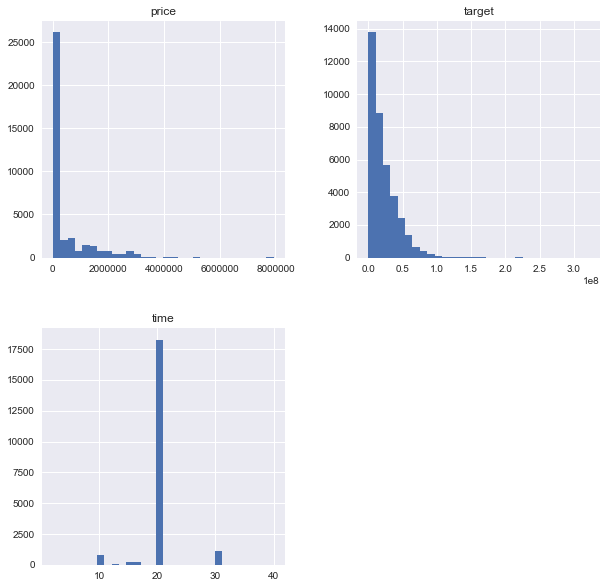

In [67]:
continuous = train[['time', 'price', 'target']]
continuous.hist(bins=30, figsize=(10,10))
plt.show()

time 그래프를 보면 방송에 노출되는 시간이 대체로 20임을 알 수 있었습니다. 따라서 time에 있는 결측치를 20으로 대체하기로 합니다. 

In [84]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
train['time'] = imputer.fit_transform(train[['time']])

train['time'].isnull().sum()

0

In [87]:
test['time'] = imputer.transform(test[['time']])

test['time'].isnull().sum()

0

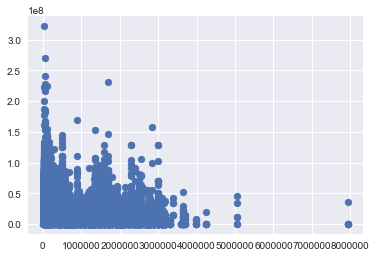

In [76]:
# price 이상치 확인
plt.scatter(x=continuous['price'], y=continuous['target'])

In [78]:
train[train.price>7000000]

,date,time,code1,code2,product,category,price,target
30154,2019-10-11 8:00,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,50000
30161,2019-10-11 8:30,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,36072000
30964,2019-10-19 8:00,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,50000
30971,2019-10-19 8:30,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,50000
31491,2019-10-24 8:00,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,50000
31498,2019-10-24 8:30,NaN,100788,202330,[루이띠에] 순금 70g 골드바,잡화,7930000,50000


상품이 골드바인것을 보면 가능한 값이라 생각되므로 제거하지 않습니다. 

### 범주형 변수
- 마더코드, 상품코드, 상품군 확인

In [93]:
code1_count = train['code1'].value_counts()
code1_count

100148    2618
100837    1507
100448    1308
100205     792
100500     702
100203     666
100372     639
100575     636
100155     620
100150     604
100149     540
100074     488
100610     465
100765     444
100577     408
100255     401
100097     390
100139     372
100786     350
100182     348
100253     318
100037     293
100067     288
100501     284
100088     270
100251     268
100849     264
100281     257
100489     252
100010     252
100731     242
100189     237
100305     231
100290     216
100322     211
100374     208
100613     206
100654     200
100763     184
100742     183
100166     182
100377     175
100607     171
100373     168
100127     162
100352     160
100618     150
100202     147
100770     144
100766     141
100788     140
100293     138
100167     137
100271     136
100832     136
100635     135
100597     134
100545     132
100130     126
100231     126
100604     126
100452     126
100226     124
100809     123
100511     122
100483     122
100046    

In [94]:
code2_count = train['code2'].value_counts()
code2_count

200864    318
200868    282
200465    273
200533    273
200014    252
         ... 
200482      2
202497      2
202337      2
202335      2
201358      2
Name: code2, Length: 2042, dtype: int64

In [95]:
category_count = train['category'].value_counts()
category_count

주방      6604
가전      6479
의류      4340
속옷      3919
잡화      3891
농수축     3884
생활용품    2877
가구      2614
이미용     1305
건강기능     790
침구       669
Name: category, dtype: int64

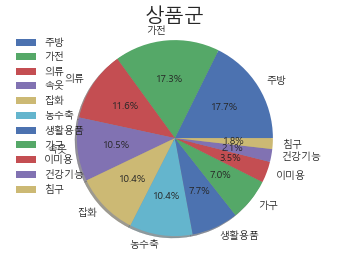

In [101]:
# 상품군 시각화
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', shadow=True)
plt.title('상품군', size=20)
plt.legend(loc='best')
plt.axis('equal')
plt.show()

### 범주형 변수 Encoding

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 8 columns):
date        37372 non-null object
time        37372 non-null float64
code1       37372 non-null int64
code2       37372 non-null int64
product     37372 non-null object
category    37372 non-null object
price       37372 non-null int64
target      37372 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.6+ MB


In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2716 entries, 0 to 2890
Data columns (total 8 columns):
date        2716 non-null object
time        2716 non-null float64
code1       2716 non-null int64
code2       2716 non-null int64
product     2716 non-null object
category    2716 non-null object
price       2716 non-null int64
target      0 non-null float64
dtypes: float64(2), int64(3), object(3)
memory usage: 191.0+ KB


범주형 변수 인코딩을 위해 train과 test 데이터 셋을 합친 데이터셋을 만듭니다

In [91]:
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.shape

(40088, 8)

In [106]:
from sklearn.preprocessing import LabelEncoder

In [107]:
def category_encoding(data, col):
    le = LabelEncoder()
    le.fit(data[col])
    data[col] = le.transform(data[col])
    return data[col]

In [108]:
category_encoding(all_data, 'code1')
category_encoding(all_data, 'code2')
category_encoding(all_data, 'product')
category_encoding(all_data, 'category')

0        6
1        6
2        6
3        6
4        6
        ..
40083    5
40084    5
40085    5
40086    6
40087    6
Name: category, Length: 40088, dtype: int32

In [112]:
# date encoding

all_data['date'] = all_data['date'].apply(lambda x: time.mktime(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M').timetuple()))

In [113]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40088 entries, 0 to 40087
Data columns (total 8 columns):
date        40088 non-null float64
time        40088 non-null float64
code1       40088 non-null int64
code2       40088 non-null int64
product     40088 non-null int32
category    40088 non-null int32
price       40088 non-null int64
target      37372 non-null float64
dtypes: float64(3), int32(2), int64(3)
memory usage: 2.1 MB


In [114]:
all_data.head()

,date,time,code1,code2,product,category,price,target
0,1.546290e+09,20.0,335,1060,1778,6,39900,2099000.0
1,1.546290e+09,20.0,335,1067,1784,6,39900,4371000.0
2,1.546291e+09,20.0,335,1060,1778,6,39900,3262000.0
3,1.546291e+09,20.0,335,1067,1784,6,39900,6955000.0
4,1.546292e+09,20.0,335,1060,1778,6,39900,6672000.0


### all_data 데이터셋 분리

In [115]:
train = all_data[: len(train)]
test = all_data[len(train):]

In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 8 columns):
date        37372 non-null float64
time        37372 non-null float64
code1       37372 non-null int64
code2       37372 non-null int64
product     37372 non-null int32
category    37372 non-null int32
price       37372 non-null int64
target      37372 non-null float64
dtypes: float64(3), int32(2), int64(3)
memory usage: 2.0 MB


In [117]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 37372 to 40087
Data columns (total 8 columns):
date        2716 non-null float64
time        2716 non-null float64
code1       2716 non-null int64
code2       2716 non-null int64
product     2716 non-null int32
category    2716 non-null int32
price       2716 non-null int64
target      0 non-null float64
dtypes: float64(3), int32(2), int64(3)
memory usage: 148.7 KB


## Modeling

In [149]:
# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

### target 분리, data split

In [185]:
y = train['target']
X = train.loc[:, train.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)

In [186]:
# update test data
test = test.loc[:, test.columns != 'target']
test.head()

,date,time,code1,code2,product,category,price
37372,1.590960e+09,20.0,616,1887,1592,6,59800
37373,1.590961e+09,20.0,616,1887,1592,6,59800
37374,1.590962e+09,20.0,616,1887,1592,6,59800
37375,1.590964e+09,20.0,431,2182,1736,5,69900
37376,1.590965e+09,20.0,431,2182,1736,5,69900


### validation function

In [187]:
def mape(y, y_pred):
    return mean_absolute_error(y, y_pred)

### Base models

- Regression

In [188]:
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

lasso = make_pipeline(StandardScaler(), Lasso())
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

ridge = make_pipeline(StandardScaler(), Ridge())
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 14228392.3427
test accuracy : 14228392.6356
test accuracy : 14228440.0752


- DecisionTreeRegressor

In [189]:
dt = make_pipeline(StandardScaler(), DecisionTreeRegressor())
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 11366542.2761


- Random Forest

In [190]:
rf = make_pipeline(RandomForestRegressor())
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 10045114.2383


- GBM

In [191]:
gbm = make_pipeline(GradientBoostingRegressor())
gbm.fit(X_train, y_train)
pred = gbm.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 11424251.3920


- XGBoost

In [192]:
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train, y_train)
pred = xgboost.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 9491064.3576


- LightGBM

In [193]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
print('test accuracy : {0:.4f}'.format(mape(y_test,pred)))

test accuracy : 9852264.5521


### 1. Voting 

In [194]:
vo_reg = VotingRegressor(estimators=[('lr', lr), ('dt', dt), ('rf', rf)])

vo_reg.fit(X_train, y_train)
pred = vo_reg.predict(X_test)
print('voitng regressor accuracy: {0:.4f}'.format(mape(y_test, pred)))


voitng regressor accuracy: 10463552.7889


### 2. Bagging

In [195]:
bag_reg = BaggingRegressor(base_estimator=xgboost)

bag_reg.fit(X_train, y_train)
pred = bag_reg.predict(X_test)
print('bagging regressor accuracy: {0:.4f}'.format(mape(y_test, pred)))

bagging regressor accuracy: 9357182.8373


### 3. AdaBoost

In [196]:
ada_reg = AdaBoostRegressor()

ada_reg.fit(X_train, y_train)
pred = ada_reg.predict(X_test)
print('adaboost regressor accuracy: {0:.4f}'.format(mape(y_test, pred)))

adaboost regressor accuracy: 25577511.1843


### 4. Basic Stacking

In [197]:
# 개별 모델 lr, rf, dt -> 최종모델 xgb

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
dt_pred = dt.predict(X_test)

- stacking 개별 모델 합치기

In [198]:
new_data = np.array([lr_pred, rf_pred, dt_pred])
new_data.shape

(3, 11212)

- shape 변경

In [199]:
new_data = np.transpose(new_data)
new_data.shape

(11212, 3)

In [200]:
xgboost.fit(new_data, y_test)
xgb_pred = xgboost.predict(new_data)

print('accuracy: {:.4f}'.format(mape(y_test, xgb_pred)))

accuracy: 7049737.4625


### 5. Stacking : Averaged base model

In [201]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([
            model.predict(X_test) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [202]:
averaged_models = AveragingModels(models = (dt, rf, lgbm))
averaged_models.fit(X_train, y_train)
pred = averaged_models.predict(X_test)
print('accuracy : {:.4f}'.format(mape(y_test, pred)))

accuracy : 4199490.1850


### 6. Stacking : Adding a Meta-model

In [203]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=10):
  kfold = KFold(n_splits = n_folds, random_state = 1004)
  
  # 최종 모델에서 사용할 데이터 셋 세팅 (0 값으로)
  # 만약 shape가 (100,10)이었으면 폴드의 검증 과정 중 저장할 데이터는 (100,1)으로 한다.
  train_fold_predict = np.zeros((X_train.shape[0],1))
  # test 는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold갯수) 모양이다.
  # 해당 폴드마다 X_test의 예측 값을 fold 에 넣는다! meta model 이 쓸꺼임
  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]

    # 학습
    model.fit(X_train_,y_train_)
    # 해당 폴드에서 학습된 모델에다가 검증 데이터 (X_valid)로 예측 후 저장
    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)
    # 해당 폴드에서 생성된 모델에게 원본 테스트 데이터 (X_test)를 이용해서 예측하고 저장
    test_predict[:,cnt] = model.predict(X_test)
  
  # for 문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [204]:
# base model = dt, rf, lgbm
dt_train, dt_test = get_stacking_data(dt, X_train, y_train, X_test)
rf_train, rf_test = get_stacking_data(rf, X_train, y_train, X_test)
lgbm_train, lgbm_test = get_stacking_data(lgbm, X_train, y_train, X_test)

model :  Pipeline
model :  Pipeline
model :  LGBMRegressor


In [205]:
new_X_train = np.concatenate((dt_train, rf_train, lgbm_train), axis=1)
new_X_test = np.concatenate((dt_test, rf_test, lgbm_test), axis=1)

print('orginal: ', X_train.shape, X_test.shape)
print('new: ', new_X_train.shape, new_X_test.shape)

orginal:  (26160, 7) (11212, 7)
new:  (26160, 3) (11212, 3)


In [206]:
xgboost.fit(new_X_train, y_train)
pred = xgboost.predict(new_X_test)
print('accuracy: {:.4f}'.format(mape(y_test, pred)))


accuracy: 9344136.1069


정리 : ensemble을 시도하면, base model 보다 mape를 낮출 수 있었으나, 기본적으로 모두 오차율이 크게 나왔습니다. 
아무래도 기존 feature만으로는 target을 잘 설명할 수 없는 것 같습니다. 